In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pywt
import os

# Для Jupyter
%matplotlib inline

Размер матрицы: (531, 413)
Тип данных: float64
Диапазон значений: [0.0, 255.0]


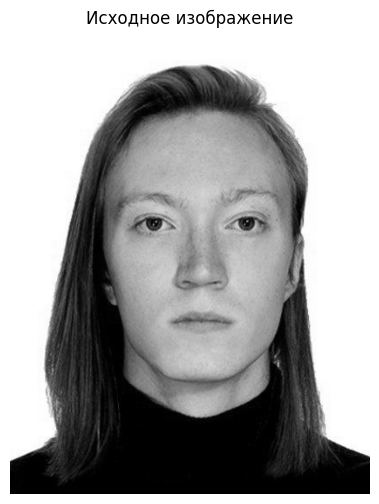

In [11]:
# === ЗАГРУЗКА И АНАЛИЗ ИЗОБРАЖЕНИЯ ===
# Загрузка и преобразование в ч/б
image = Image.open('1.jpg').convert('L')
image_array = np.array(image, dtype=float)

print(f"Размер матрицы: {image_array.shape}")
print(f"Тип данных: {image_array.dtype}")
print(f"Диапазон значений: [{image_array.min()}, {image_array.max()}]")

# Показываем исходное изображение
plt.figure(figsize=(8, 6))
plt.imshow(image_array, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

Используемый вейвлет: db4
Уровень разложения: 4

Всего вейвлет-коэффициентов: 244523


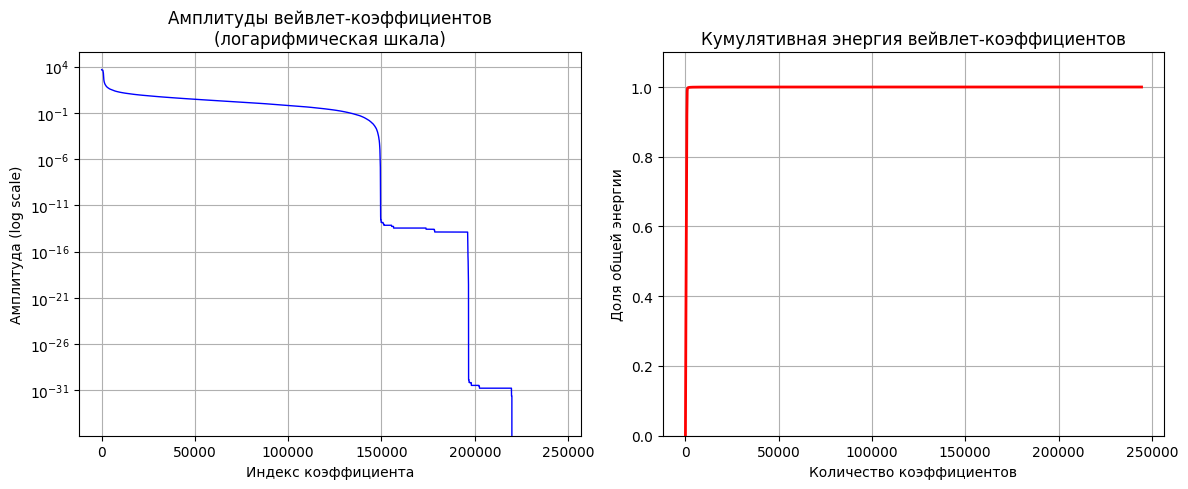

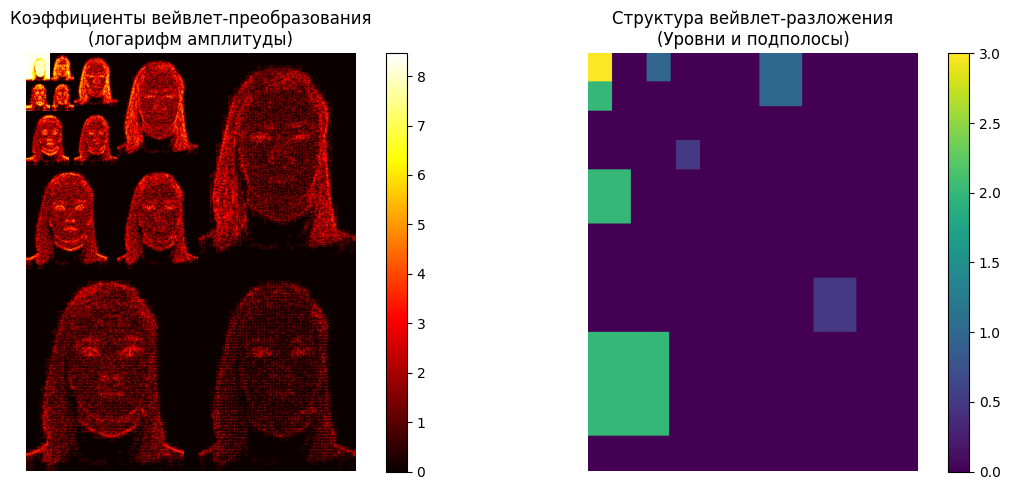

In [12]:
# === ВЕЙВЛЕТ-ПРЕОБРАЗОВАНИЕ И АНАЛИЗ ===

# Параметры вейвлет-преобразования
wavelet_name = 'db4'
level = 4

print(f"Используемый вейвлет: {wavelet_name}")
print(f"Уровень разложения: {level}")

# Выполняем многоуровневое вейвлет-разложение
coeffs = pywt.wavedec2(image_array, wavelet=wavelet_name, level=level)

# Преобразуем коэффициенты в один массив для обработки
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

# Получаем амплитуды коэффициентов и сортируем по убыванию
magnitudes = np.abs(coeff_arr)
magnitudes_sorted = np.sort(magnitudes.ravel())[::-1]

# Общее количество коэффициентов
total_coeffs = len(magnitudes_sorted)
print(f"\nВсего вейвлет-коэффициентов: {total_coeffs}")

# Вычисляем кумулятивную энергию
cumulative_energy = np.cumsum(magnitudes_sorted**2) / np.sum(magnitudes_sorted**2)

# График амплитуд коэффициентов и кумулятивной энергии
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(magnitudes_sorted, 'b-', linewidth=1)
plt.title('Амплитуды вейвлет-коэффициентов\n(логарифмическая шкала)')
plt.xlabel('Индекс коэффициента')
plt.ylabel('Амплитуда (log scale)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cumulative_energy, 'r-', linewidth=2)
plt.title('Кумулятивная энергия вейвлет-коэффициентов')
plt.xlabel('Количество коэффициентов')
plt.ylabel('Доля общей энергии')
plt.grid(True)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Визуализация коэффициентов вейвлета
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
coeff_vis = np.log(1 + np.abs(coeff_arr))
plt.imshow(coeff_vis, cmap='hot')
plt.title('Коэффициенты вейвлет-преобразования\n(логарифм амплитуды)')
plt.axis('off')
plt.colorbar()

# Визуализация структуры разложения
plt.subplot(1, 2, 2)
# Создаем визуализацию структуры вейвлет-коэффициентов
structure_vis = np.zeros_like(coeff_arr)
current_idx = 0

for i, coeff in enumerate(coeffs):
    if i == 0:
        # Аппроксимирующие коэффициенты
        size = coeff.shape
        structure_vis[current_idx:current_idx+size[0], current_idx:current_idx+size[1]] = 3
        current_idx += size[0]
    else:
        # Детализирующие коэффициенты
        for j, detail_coeff in enumerate(coeff):
            size = detail_coeff.shape
            if j == 0:  # Horizontal
                structure_vis[current_idx:current_idx+size[0], :size[1]] = 2
            elif j == 1:  # Vertical
                structure_vis[:size[0], current_idx:current_idx+size[1]] = 1
            else:  # Diagonal
                structure_vis[current_idx:current_idx+size[0], current_idx:current_idx+size[1]] = 0.5
            current_idx += size[0]

plt.imshow(structure_vis, cmap='viridis')
plt.title('Структура вейвлет-разложения\n(Уровни и подполосы)')
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()

In [13]:
# === ФУНКЦИИ ДЛЯ ВЕЙВЛЕТ-СЖАТИЯ ===

def compress_wavelet(coeff_arr, keep_ratio):
    """
    Сжатие вейвлет-коэффициентов - сохранение только максимальных по амплитуде
    """
    # Получаем амплитуды коэффициентов
    magnitudes = np.abs(coeff_arr)
    
    # Вычисляем порог для сохранения указанного процента коэффициентов
    total_coeffs = coeff_arr.size
    keep_count = int(total_coeffs * keep_ratio)
    
    # Находим пороговое значение
    if keep_count > 0:
        threshold = np.partition(magnitudes.ravel(), -keep_count)[-keep_count]
    else:
        threshold = np.max(magnitudes) + 1
    
    # Создаем маску для коэффициентов выше порога
    mask = magnitudes >= threshold
    
    # Применяем маску - обнуляем малые коэффициенты
    compressed_coeffs = coeff_arr * mask
    
    return compressed_coeffs, mask, keep_count

def reconstruct_from_wavelet(compressed_coeffs, coeff_slices, wavelet_name, original_shape):
    """Восстановление изображения из сжатых вейвлет-коэффициентов"""
    # Преобразуем обратно в структуру коэффициентов
    coeffs_fill = pywt.array_to_coeffs(compressed_coeffs, coeff_slices, output_format='wavedec2')
    
    # Обратное вейвлет-преобразование
    reconstructed = pywt.waverec2(coeffs_fill, wavelet=wavelet_name)
    
    # Обрезаем до исходного размера
    reconstructed = reconstructed[:original_shape[0], :original_shape[1]]
    
    # Ограничиваем значения в диапазоне 0-255
    reconstructed = np.clip(reconstructed, 0, 255)
    
    return reconstructed.astype(np.uint8)


РЕЗУЛЬТАТЫ СЖАТИЯ С ПОМОЩЬЮ ВЕЙВЛЕТ-ПРЕОБРАЗОВАНИЯ
Уровень    Коэфф.   % энергии    Ошибка Фробениуса   
------------------------------------------------------------
10%        24452    99.99     % 879.45              
5%         12226    99.99     % 1391.11             
1%         2445     99.91     % 3261.79             
0.5%       1222     99.72     % 5793.28             


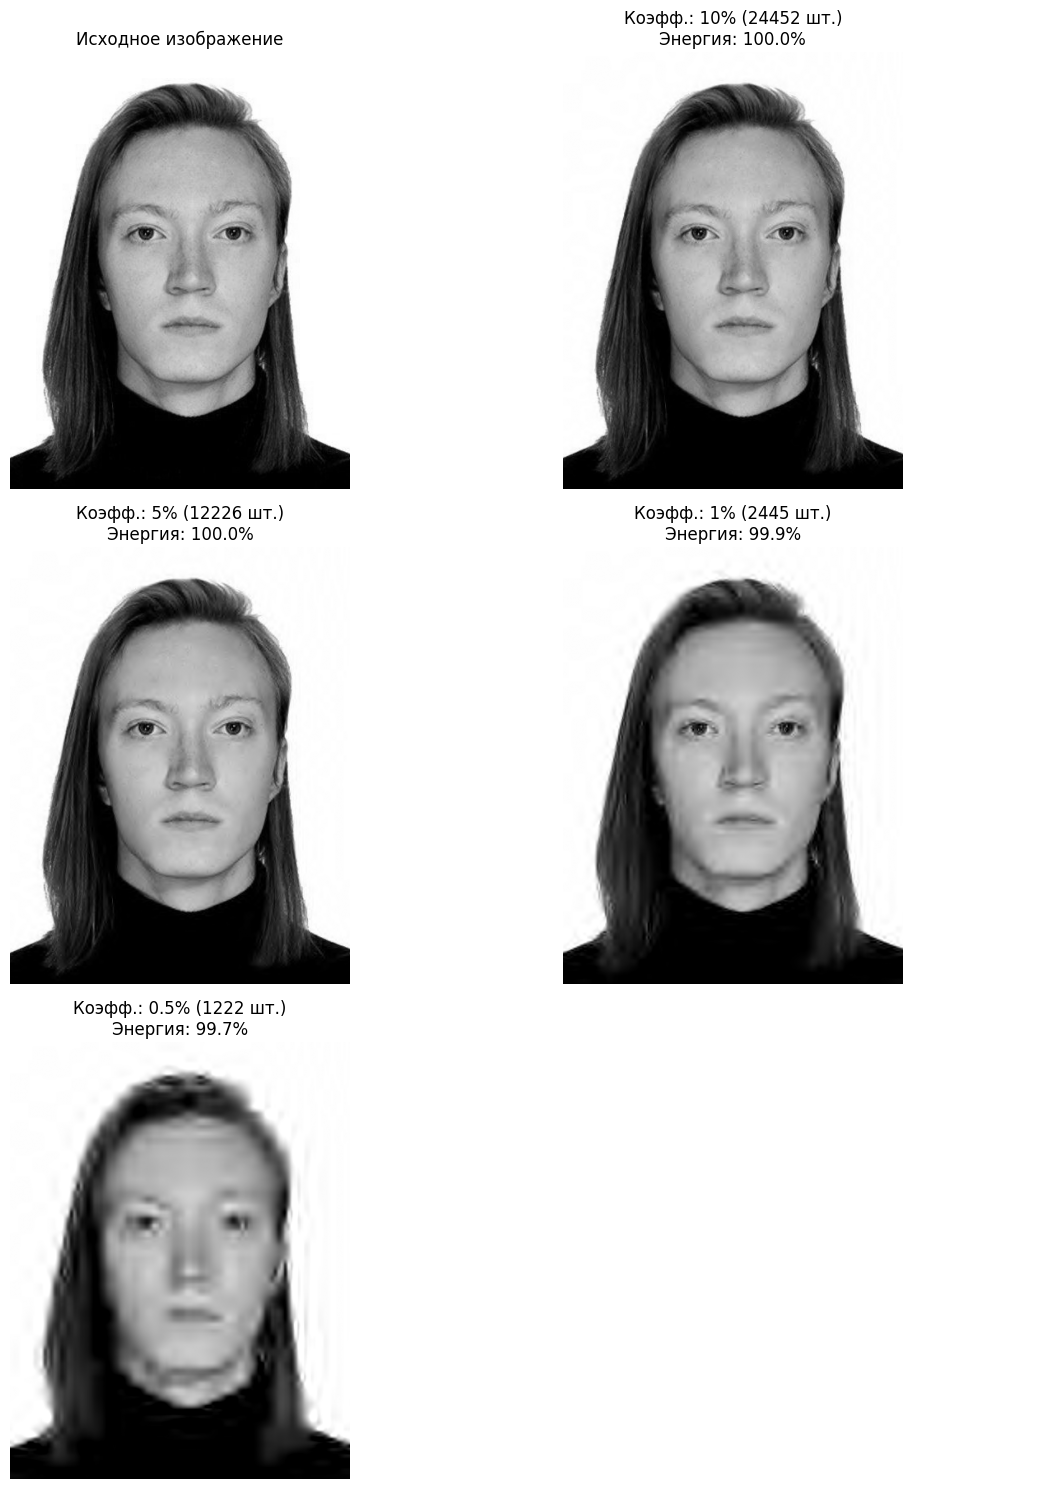

In [14]:
# === ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ СЖАТИЯ ===

# Проценты для усечения
compression_ratios = [0.10, 0.05, 0.01, 0.005]
ratios_names = ['10%', '5%', '1%', '0.5%']

print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ СЖАТИЯ С ПОМОЩЬЮ ВЕЙВЛЕТ-ПРЕОБРАЗОВАНИЯ")
print("="*80)
print(f"{'Уровень':<10} {'Коэфф.':<8} {'% энергии':<12} {'Ошибка Фробениуса':<20}")
print("-" * 60)

# ИСПРАВЛЕНИЕ: создаем сетку 3×2 для 4 результатов + 1 исходное
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.ravel()  # Преобразуем в одномерный массив

# Исходное изображение
axes[0].imshow(image_array, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

# Восстановленные изображения для разных уровней сжатия
for i, (ratio, name) in enumerate(zip(compression_ratios, ratios_names)):
    # Сжимаем вейвлет-коэффициенты
    compressed_coeffs, mask, kept_coeffs = compress_wavelet(coeff_arr, ratio)
    
    # Восстанавливаем изображение
    reconstructed = reconstruct_from_wavelet(compressed_coeffs, coeff_slices, wavelet_name, image_array.shape)
    
    # Вычисляем процент энергии
    total_energy = np.sum(magnitudes_sorted**2)
    kept_energy = np.sum((np.abs(compressed_coeffs))**2)
    energy_percentage = (kept_energy / total_energy) * 100
    
    # Вычисляем норму Фробениуса ошибки
    error_norm = np.linalg.norm(image_array - reconstructed, 'fro')
    
    print(f"{name:<10} {kept_coeffs:<8} {energy_percentage:<10.2f}% {error_norm:<20.2f}")
    
    # Визуализируем результат (i+1 потому что 0 занят исходным)
    axes[i+1].imshow(reconstructed, cmap='gray')
    axes[i+1].set_title(f'Коэфф.: {name} ({kept_coeffs} шт.)\nЭнергия: {energy_percentage:.1f}%')
    axes[i+1].axis('off')

# Скрываем оставшиеся пустые subplot'ы
total_plots_used = len(compression_ratios) + 1
for j in range(total_plots_used, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

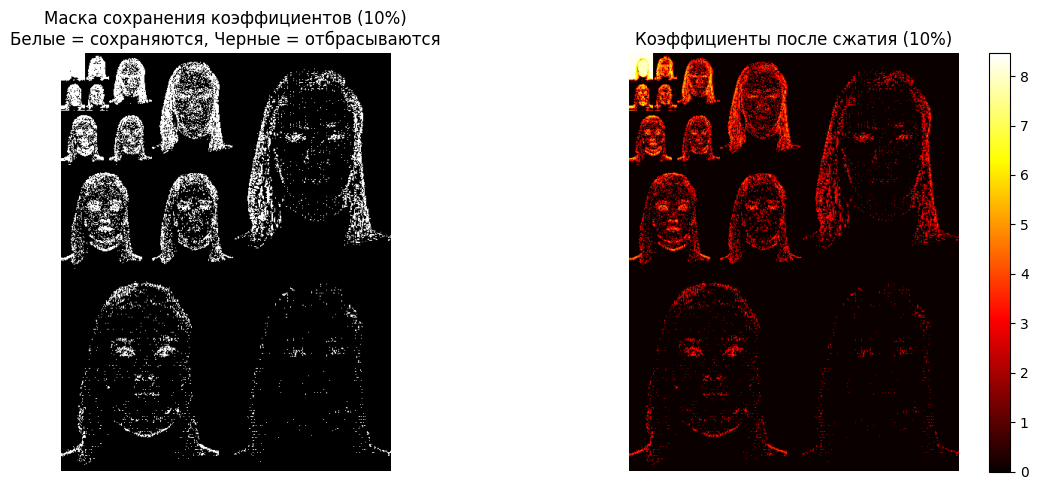

Для уровня 10% сохранено 24452 коэффициентов из 244523


In [15]:
# === ВИЗУАЛИЗАЦИЯ МАСКИ СЖАТИЯ ===

# Покажем маску сжатия для уровня 10%
compressed_coeffs_10, mask_10, kept_10 = compress_wavelet(coeff_arr, 0.10)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(mask_10.astype(float), cmap='gray')
plt.title('Маска сохранения коэффициентов (10%)\nБелые = сохраняются, Черные = отбрасываются')
plt.axis('off')

plt.subplot(1, 2, 2)
coeff_vis_compressed = np.log(1 + np.abs(compressed_coeffs_10))
plt.imshow(coeff_vis_compressed, cmap='hot')
plt.title('Коэффициенты после сжатия (10%)')
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()

print(f"Для уровня 10% сохранено {kept_10} коэффициентов из {coeff_arr.size}")

In [16]:
# === АНАЛИЗ ЭФФЕКТИВНОСТИ СЖАТИЯ ===

print("\n" + "="*80)
print("ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ")
print("="*80)
print(f"Размер исходной матрицы: {image_array.shape}")
print(f"Общее количество элементов: {image_array.size}")
print(f"Размер массива коэффициентов: {coeff_arr.shape}")

# Экономия памяти для разных уровней сжатия
print("\nЭКОНОМИЯ ПАМЯТИ:")
print(f"{'Уровень':<10} {'Коэфф.':<8} {'Исходный размер':<18} {'Сжатый размер':<16} {'Коэф. сжатия':<12}")
print("-" * 70)

m, n = image_array.shape
for ratio, name in zip(compression_ratios, ratios_names):
    kept_coeffs = int(coeff_arr.size * ratio)
    
    # Исходный размер (в элементах)
    original_size = m * n
    
    # Размер сжатого представления: храним только выбранные коэффициенты
    # Для каждого коэффициента: значение + позиция
    compressed_size = kept_coeffs * 2  # значения (вещественные)
    
    compression_ratio = original_size / compressed_size if compressed_size > 0 else float('inf')
    
    print(f"{name:<10} {kept_coeffs:<8} {original_size:<18} {compressed_size:<16} {compression_ratio:<10.2f}x")

# Альтернативный расчет (просто по количеству коэффициентов)
print("\nАЛЬТЕРНАТИВНЫЙ РАСЧЕТ (только коэффициенты):")
print(f"{'Уровень':<10} {'Коэфф.':<8} {'Исходные':<12} {'Сохраненные':<12} {'Коэф. сжатия':<12}")
print("-" * 60)

total_coeffs = coeff_arr.size
for ratio, name in zip(compression_ratios, ratios_names):
    kept_coeffs = int(total_coeffs * ratio)
    compression_simple = total_coeffs / kept_coeffs if kept_coeffs > 0 else float('inf')
    
    print(f"{name:<10} {kept_coeffs:<8} {total_coeffs:<12} {kept_coeffs:<12} {compression_simple:<10.2f}x")


ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
Размер исходной матрицы: (531, 413)
Общее количество элементов: 219303
Размер массива коэффициентов: (557, 439)

ЭКОНОМИЯ ПАМЯТИ:
Уровень    Коэфф.   Исходный размер    Сжатый размер    Коэф. сжатия
----------------------------------------------------------------------
10%        24452    219303             48904            4.48      x
5%         12226    219303             24452            8.97      x
1%         2445     219303             4890             44.85     x
0.5%       1222     219303             2444             89.73     x

АЛЬТЕРНАТИВНЫЙ РАСЧЕТ (только коэффициенты):
Уровень    Коэфф.   Исходные     Сохраненные  Коэф. сжатия
------------------------------------------------------------
10%        24452    244523       24452        10.00     x
5%         12226    244523       12226        20.00     x
1%         2445     244523       2445         100.01    x
0.5%       1222     244523       1222         200.10    x



ЭКСПЕРИМЕНТ С РАЗНЫМ ЧИСЛОМ УРОВНЕЙ РАЗЛОЖЕНИЯ
Уровень  Коэфф.   Ошибка       % энергии   
--------------------------------------------------
1        11298    51500.27     63.78     %
2        11608    4562.38      99.71     %
3        11901    1485.88      99.98     %
4        12226    1391.11      99.99     %
5        12549    1368.61      99.99     %


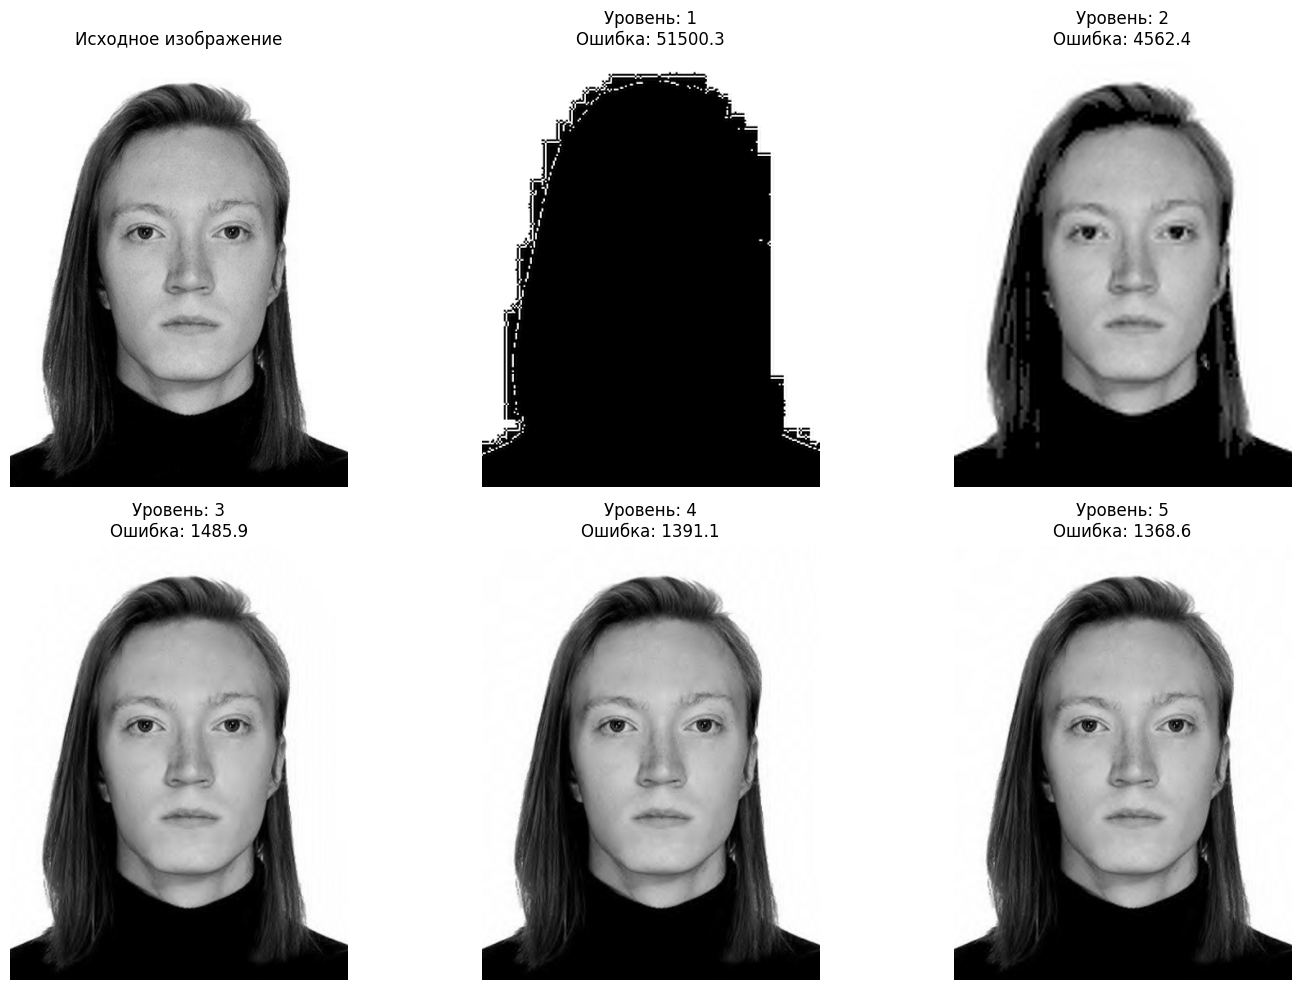

In [17]:
# === ЭКСПЕРИМЕНТ С РАЗНЫМИ УРОВНЯМИ РАЗЛОЖЕНИЯ ===

print("\n" + "="*80)
print("ЭКСПЕРИМЕНТ С РАЗНЫМ ЧИСЛОМ УРОВНЕЙ РАЗЛОЖЕНИЯ")
print("="*80)

levels_to_test = [1, 2, 3, 4, 5]
ratio = 0.05  # 5% коэффициентов

# ИСПРАВЛЕНИЕ: создаем сетку 2×3 для 5 уровней + 1 исходное
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()  # Преобразуем в одномерный массив

# Исходное изображение
axes[0].imshow(image_array, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

print(f"{'Уровень':<8} {'Коэфф.':<8} {'Ошибка':<12} {'% энергии':<12}")
print("-" * 50)

for i, level in enumerate(levels_to_test):
    try:
        # Выполняем вейвлет-разложение с текущим уровнем
        coeffs_current = pywt.wavedec2(image_array, wavelet=wavelet_name, level=level)
        coeff_arr_current, coeff_slices_current = pywt.coeffs_to_array(coeffs_current)
        
        # Сжимаем коэффициенты
        compressed_coeffs, mask, kept_coeffs = compress_wavelet(coeff_arr_current, ratio)
        
        # Восстанавливаем изображение
        reconstructed = reconstruct_from_wavelet(compressed_coeffs, coeff_slices_current, wavelet_name, image_array.shape)
        
        # Вычисляем метрики
        error_norm = np.linalg.norm(image_array - reconstructed, 'fro')
        magnitudes_current = np.abs(coeff_arr_current)
        total_energy = np.sum(magnitudes_current**2)
        kept_energy = np.sum((np.abs(compressed_coeffs))**2)
        energy_percentage = (kept_energy / total_energy) * 100
        
        print(f"{level:<8} {kept_coeffs:<8} {error_norm:<12.2f} {energy_percentage:<10.2f}%")
        
        # Визуализируем результат
        axes[i+1].imshow(reconstructed, cmap='gray')
        axes[i+1].set_title(f'Уровень: {level}\nОшибка: {error_norm:.1f}')
        axes[i+1].axis('off')
        
    except Exception as e:
        print(f"Ошибка для уровня {level}: {e}")
        # Безопасное обращение к axes
        if i+1 < len(axes):
            axes[i+1].axis('off')

# Скрываем последний subplot если не используется
total_plots_used = len(levels_to_test) + 1
if total_plots_used < len(axes):
    for j in range(total_plots_used, len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()


СРАВНЕНИЕ РАЗНЫХ ВЕЙВЛЕТОВ
Вейвлет  Коэфф.   Ошибка       % энергии   
--------------------------------------------------
haar     11080    1921.72      99.95     %
db1      11080    1921.72      99.95     %
db4      12226    1391.11      99.99     %
db8      13865    1395.23      99.99     %
sym4     12226    1378.58      99.98     %
coif2    13087    1341.55      99.99     %


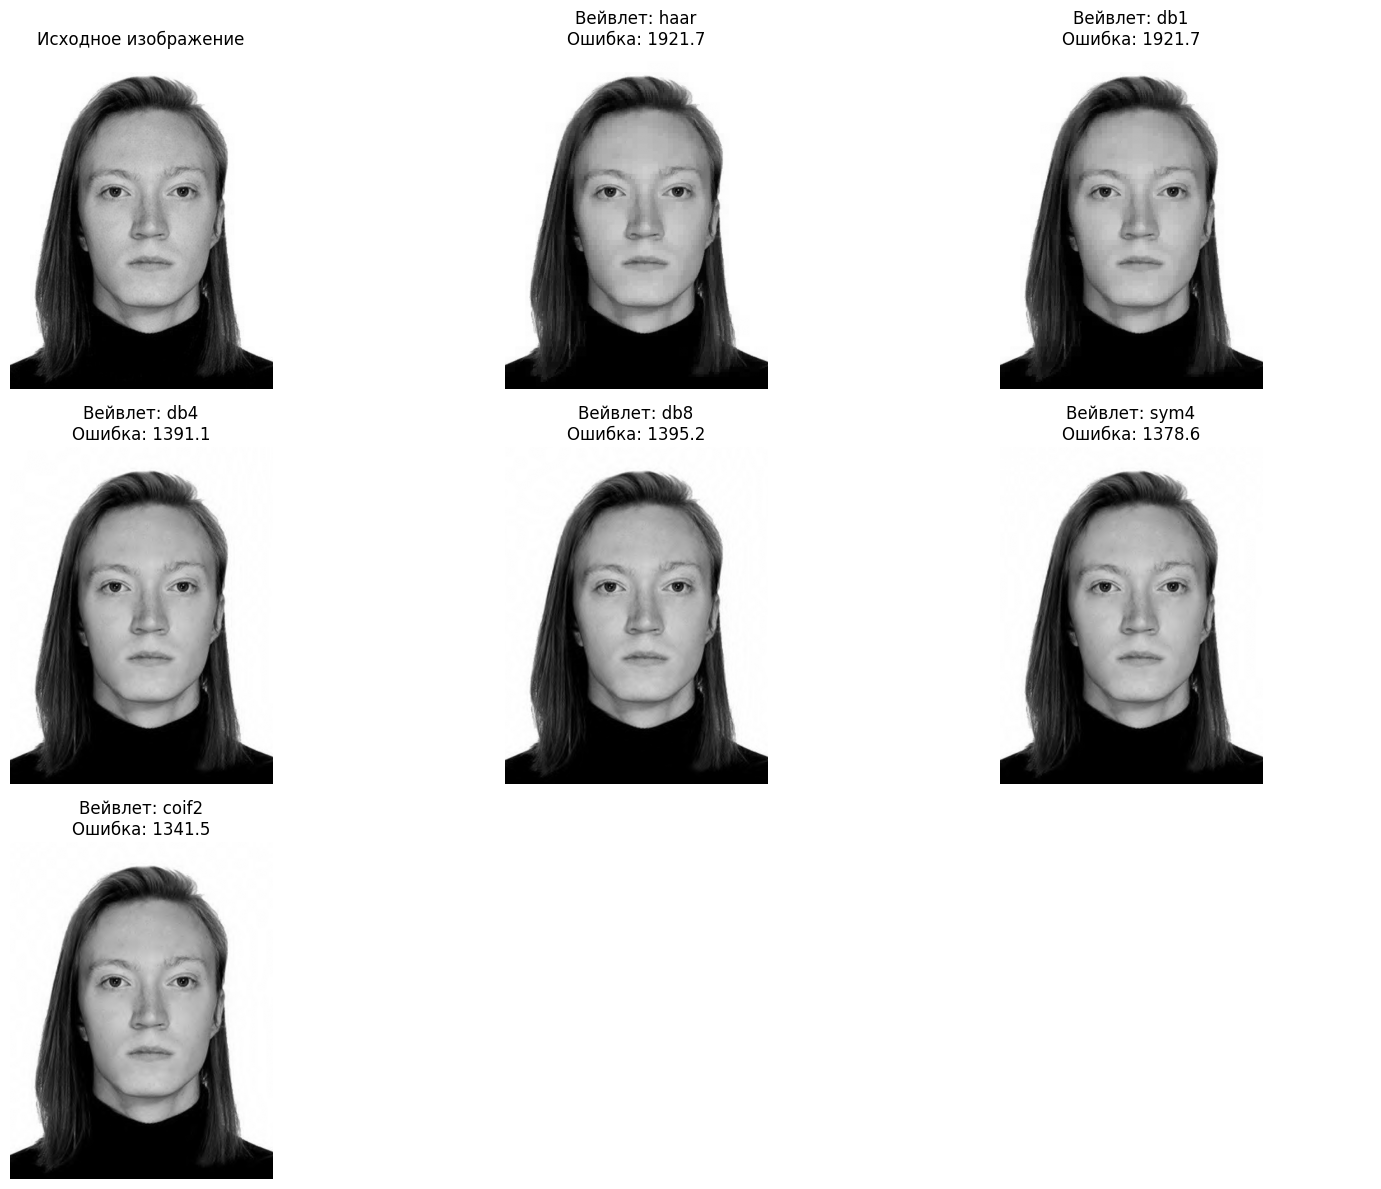

In [18]:
# === СРАВНЕНИЕ РАЗНЫХ ВЕЙВЛЕТОВ ===

print("\n" + "="*80)
print("СРАВНЕНИЕ РАЗНЫХ ВЕЙВЛЕТОВ")
print("="*80)

wavelets_to_test = ['haar', 'db1', 'db4', 'db8', 'sym4', 'coif2']
ratio = 0.05  # 5% коэффициентов
level = 4

# ИСПРАВЛЕНИЕ: создаем сетку 3×3 для 6 вейвлетов + 1 исходное
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()  # Преобразуем в одномерный массив

print(f"{'Вейвлет':<8} {'Коэфф.':<8} {'Ошибка':<12} {'% энергии':<12}")
print("-" * 50)

# Исходное изображение
axes[0].imshow(image_array, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

for i, wavelet in enumerate(wavelets_to_test):
    try:
        # Выполняем вейвлет-разложение
        coeffs_wavelet = pywt.wavedec2(image_array, wavelet=wavelet, level=level)
        coeff_arr_wavelet, coeff_slices_wavelet = pywt.coeffs_to_array(coeffs_wavelet)
        
        # Сжимаем коэффициенты
        compressed_coeffs, mask, kept_coeffs = compress_wavelet(coeff_arr_wavelet, ratio)
        
        # Восстанавливаем изображение
        reconstructed = reconstruct_from_wavelet(compressed_coeffs, coeff_slices_wavelet, wavelet, image_array.shape)
        
        # Вычисляем метрики
        error_norm = np.linalg.norm(image_array - reconstructed, 'fro')
        magnitudes_wavelet = np.abs(coeff_arr_wavelet)
        total_energy = np.sum(magnitudes_wavelet**2)
        kept_energy = np.sum((np.abs(compressed_coeffs))**2)
        energy_percentage = (kept_energy / total_energy) * 100
        
        print(f"{wavelet:<8} {kept_coeffs:<8} {error_norm:<12.2f} {energy_percentage:<10.2f}%")
        
        # Визуализируем результат (i+1 потому что 0 занят исходным)
        axes[i+1].imshow(reconstructed, cmap='gray')
        axes[i+1].set_title(f'Вейвлет: {wavelet}\nОшибка: {error_norm:.1f}')
        axes[i+1].axis('off')
        
    except Exception as e:
        print(f"Ошибка для вейвлета {wavelet}: {e}")
        # Безопасное обращение к axes
        if i+1 < len(axes):
            axes[i+1].axis('off')

# Скрываем оставшиеся пустые subplot'ы
total_plots_used = len(wavelets_to_test) + 1
for j in range(total_plots_used, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()